In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm

import torch
import torch.nn as nn
from torch.autograd import Variable
import random  
import math
import time
from matplotlib import colors

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
np.random.seed(100)
torch.manual_seed(100)
random.seed(11)

/Users/bhavanian/myenvs/housing/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_full = pd.read_csv('byaddress_16feats_3targets_v1.csv')

In [4]:
df=df_full.drop(columns=['Frequency_of_Complaints'])
df=df.dropna()
print(df.shape)

(24608, 19)


In [5]:
df

,address,year built,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res,ct_perc_disability,ct_perc_children_under_5,ct_perc_over_65,ct_perc_low_to_no_income,ct_perc_limited_english_proficiency,ct_perc_poc,ct_perc_med_illness,ct_perc_income_200000_or_more,Severity,Index_Sum
0,"1 Abbotsford St, 02121",1900.0,3577.0,5528.0,3109.0,3109.0,2.0,1.0,2.0,20.738363,22.600321,10.016051,35.345104,45.361156,97.817014,37.262921,1.061571,5.000000,10
1,"1 Acorn St, 02108",1829.0,822.0,2939.0,2300.0,2300.0,4.0,1.0,2.0,4.102075,14.190317,12.902456,6.677796,19.580253,9.802051,42.477701,26.284658,8.000000,40
2,"1 Adams St, 02129",1857.0,1056.0,4093.0,3843.0,3843.0,4.0,1.0,1.0,6.503690,14.852399,13.376384,9.870849,23.247232,5.350554,42.309963,25.625000,5.000000,5
3,"1 Akron Pl, 02119",1890.0,1654.0,1911.0,1200.0,1200.0,2.0,1.0,1.0,18.717277,32.722513,10.994764,40.628272,51.623037,98.062827,36.766230,2.694236,5.000000,5
4,"1 Aldie St, 02134",1890.0,4014.0,4060.0,2623.0,2623.0,2.5,1.0,2.0,7.853982,5.764503,2.704031,41.556047,44.260079,47.246804,36.923550,3.987847,5.000000,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25554,"992 Washington St, 02124",1935.0,4500.0,2225.0,1350.0,1350.0,2.0,1.0,1.0,12.450884,23.207269,11.738703,32.293713,44.032416,77.087426,37.940815,6.573070,4.000000,4
25556,"995 Centre St, 02130",1984.0,13357.0,4596.0,3042.0,3042.0,1.0,1.0,1.0,9.574468,14.893617,22.340426,8.428805,30.769231,22.667758,43.445172,28.631139,5.000000,5
25557,"996 South St, 02131",1907.0,5068.0,4894.0,3116.0,3116.0,2.5,1.0,2.0,9.572582,15.205830,19.440615,13.295253,32.735868,19.539098,42.887532,11.955056,4.666667,14
25558,"998 Tremont St, 02120",1910.0,1875.0,6705.0,5364.0,5364.0,4.0,1.0,4.0,21.414729,22.835917,7.751938,61.983204,69.735142,92.474160,34.394057,1.561338,5.769231,75


### Clustering for Whole data set

In [6]:
df_ct=df.drop(columns=df.columns[2:9])

In [7]:
X=df.iloc[:,1:17].to_numpy()
X.shape

(24608, 16)

In [8]:
Y_Severity= df[['Severity']].to_numpy()
Y_IndexSum= df[['Index_Sum']].to_numpy()

In [9]:
Y_Severity.max()

10.0

In [10]:
print(Y_Severity.shape, Y_IndexSum.shape)

(24608, 1) (24608, 1)


In [11]:
pca = PCA().fit(X)
components = pca.components_
print(components[0]) #first PCA maximizes variance
#all variables are highly coorelated. 

[ 5.33661885e-05  2.33902592e-01  6.12677174e-01  5.33818103e-01
  5.33811028e-01  4.89987191e-05  4.93038066e-32  4.55215729e-04
  5.43445857e-06 -4.73502113e-05 -2.79117095e-05  1.48595799e-04
  1.20684090e-04  1.48098052e-04 -1.02920470e-05 -5.35240437e-05]


In [12]:
# we are weighing all our variables evenly
X = StandardScaler().fit_transform(X)
pca = PCA().fit(X)
components = pca.components_
print(components[0])

[ 0.01996554  0.05079908  0.09310846  0.07815939  0.07816467  0.01838881
  0.          0.05022496  0.34372477  0.32556082 -0.1296865   0.39157883
  0.37252322  0.40586439 -0.38598663 -0.35566568]


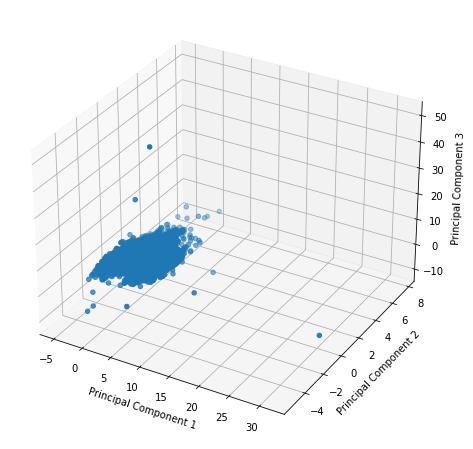

In [13]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

X_pca = pca.transform(X)
ax.scatter(X_pca[:,0], X_pca[:,5], X_pca[:,7], marker='o')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

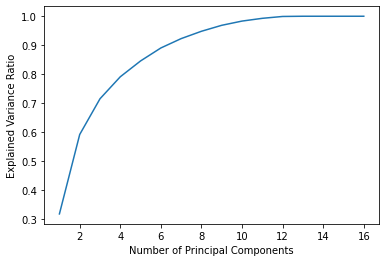

In [14]:
%matplotlib inline
plt.plot(range(1,17), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

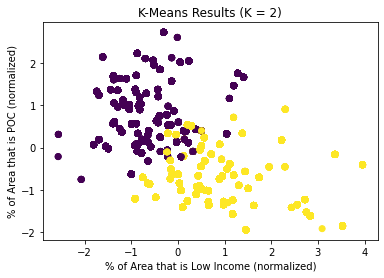

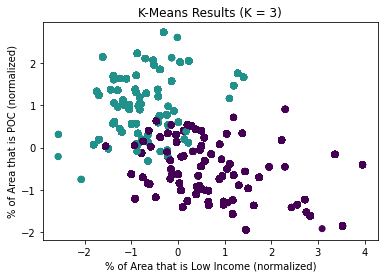

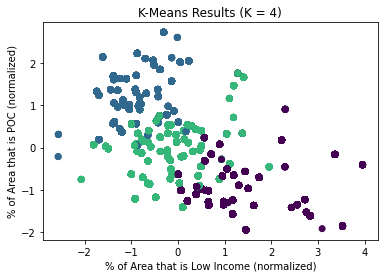

In [15]:
%matplotlib inline
for K in range(2,5):
    kmeans = KMeans(n_clusters=K).fit(X)
    plt.scatter(X[:,12], X[:,14], c=kmeans.labels_, cmap='viridis')
    #12= %low income
    #14= %POC
    plt.xlabel('% of Area that is Low Income (normalized)')
    plt.ylabel('% of Area that is POC (normalized)')
    plt.title('K-Means Results (K = ' + str(K) + ')')
    plt.show()

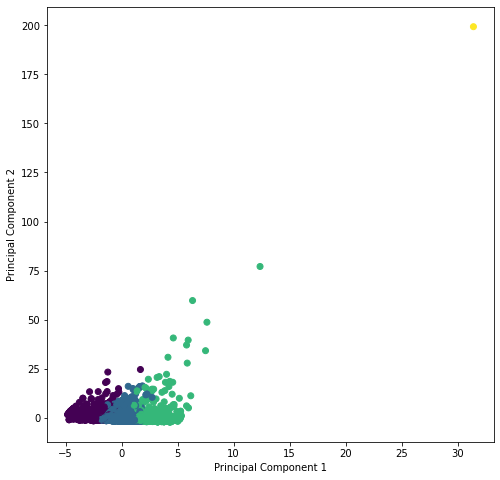

In [16]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(projection='3d')

K = 4
model = KMeans(n_clusters=K)
GMM = model.fit(X)
preds = GMM.predict(X)

X_pca = pca.transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], c=preds, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#ax.set_zlabel('Principal Component 3')
plt.show()

### For just demographics

In [17]:
X_ct=df_ct.iloc[:,2:10].to_numpy()

In [18]:
pca = PCA().fit(X_ct)
components = pca.components_
print(components[0]) #first PCA maximizes variance
#all variables are highly coorelated. 

[ 0.10363326  0.16781657 -0.03318747  0.30278046  0.269593    0.87480449
 -0.06104559 -0.16318853]


In [19]:
# we are weighing all our variables evenly
X_ct = StandardScaler().fit_transform(X_ct)
pca = PCA().fit(X_ct)
components = pca.components_
print(components[0])

[ 0.35074389  0.33602841 -0.12858957  0.39363759  0.37505554  0.41178554
 -0.39199872 -0.35872109]


In [20]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

X_ct_pca = pca.transform(X_ct)
ax.scatter(X_ct_pca[:,0], X_ct_pca[:,1], X_ct_pca[:,2], marker='o')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

<IPython.core.display.Javascript object>

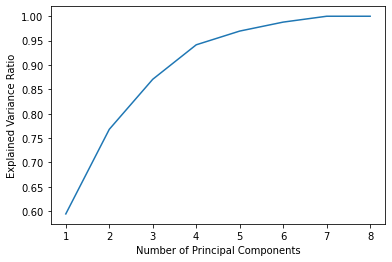

In [21]:
%matplotlib inline
plt.plot(range(1,9), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

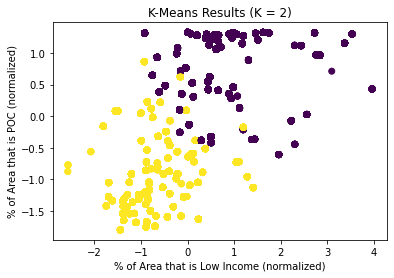

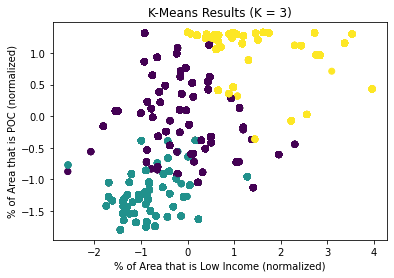

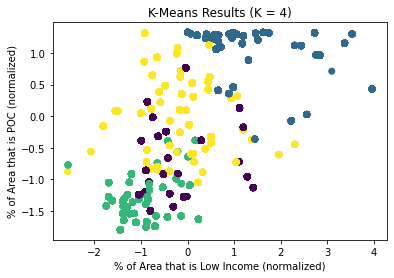

In [22]:
%matplotlib inline
for K in range(2,5):
    kmeans = KMeans(n_clusters=K).fit(X_ct)
    plt.scatter(X_ct[:,4], X_ct[:,5], c=kmeans.labels_, cmap='viridis')
    #12= %low income
    #14= %POC
    plt.xlabel('% of Area that is Low Income (normalized)')
    plt.ylabel('% of Area that is POC (normalized)')
    plt.title('K-Means Results (K = ' + str(K) + ')')
    plt.show()

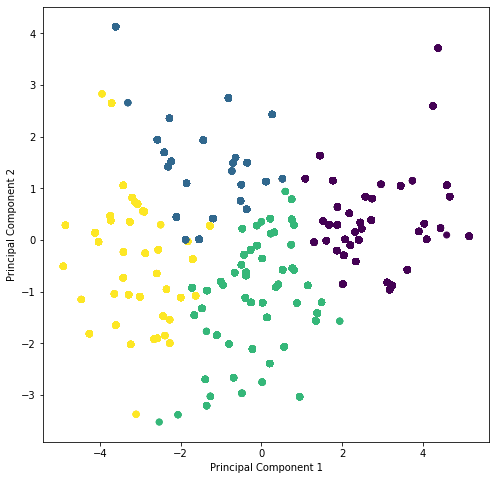

In [23]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(projection='3d')

K = 4
model = KMeans(n_clusters=K)
GMM = model.fit(X_ct)
preds = GMM.predict(X_ct)

X_ct_pca = pca.transform(X_ct)
plt.scatter(X_ct_pca[:,0], X_ct_pca[:,1], c=preds, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#ax.set_zlabel('Principal Component 3')
plt.show()

In [24]:
model.labels_

array([0, 3, 3, ..., 1, 0, 1], dtype=int32)

In [25]:
df_ct

,address,year built,ct_perc_disability,ct_perc_children_under_5,ct_perc_over_65,ct_perc_low_to_no_income,ct_perc_limited_english_proficiency,ct_perc_poc,ct_perc_med_illness,ct_perc_income_200000_or_more,Severity,Index_Sum
0,"1 Abbotsford St, 02121",1900.0,20.738363,22.600321,10.016051,35.345104,45.361156,97.817014,37.262921,1.061571,5.000000,10
1,"1 Acorn St, 02108",1829.0,4.102075,14.190317,12.902456,6.677796,19.580253,9.802051,42.477701,26.284658,8.000000,40
2,"1 Adams St, 02129",1857.0,6.503690,14.852399,13.376384,9.870849,23.247232,5.350554,42.309963,25.625000,5.000000,5
3,"1 Akron Pl, 02119",1890.0,18.717277,32.722513,10.994764,40.628272,51.623037,98.062827,36.766230,2.694236,5.000000,5
4,"1 Aldie St, 02134",1890.0,7.853982,5.764503,2.704031,41.556047,44.260079,47.246804,36.923550,3.987847,5.000000,35
...,...,...,...,...,...,...,...,...,...,...,...,...
25554,"992 Washington St, 02124",1935.0,12.450884,23.207269,11.738703,32.293713,44.032416,77.087426,37.940815,6.573070,4.000000,4
25556,"995 Centre St, 02130",1984.0,9.574468,14.893617,22.340426,8.428805,30.769231,22.667758,43.445172,28.631139,5.000000,5
25557,"996 South St, 02131",1907.0,9.572582,15.205830,19.440615,13.295253,32.735868,19.539098,42.887532,11.955056,4.666667,14
25558,"998 Tremont St, 02120",1910.0,21.414729,22.835917,7.751938,61.983204,69.735142,92.474160,34.394057,1.561338,5.769231,75


In [26]:
df_ct['Cluster']=model.labels_

In [27]:
df_ct.groupby('Cluster')['Severity'].mean()

Cluster
0    5.536036
1    5.734413
2    5.619649
3    5.692768
Name: Severity, dtype: float64

In [28]:
df_ct.corr()['Severity']

year built                             0.018328
ct_perc_disability                    -0.020606
ct_perc_children_under_5               0.003369
ct_perc_over_65                        0.066413
ct_perc_low_to_no_income              -0.057016
ct_perc_limited_english_proficiency   -0.038910
ct_perc_poc                           -0.055019
ct_perc_med_illness                    0.042762
ct_perc_income_200000_or_more          0.048908
Severity                               1.000000
Index_Sum                              0.004332
Cluster                                0.023979
Name: Severity, dtype: float64

In [29]:
df_ct_clusters=df_ct.groupby('Cluster').mean()

In [30]:
df_ct_clusters

,year built,ct_perc_disability,ct_perc_children_under_5,ct_perc_over_65,ct_perc_low_to_no_income,ct_perc_limited_english_proficiency,ct_perc_poc,ct_perc_med_illness,ct_perc_income_200000_or_more,Severity,Index_Sum
Cluster,,,,,,,,,,,
0,1913.741570,17.488862,28.652427,10.107649,41.670797,51.778446,91.696597,35.745906,3.145354,5.536036,28.946691
1,1920.451524,13.362256,18.423141,16.582907,16.492297,33.075203,37.915494,40.397982,8.871063,5.734413,16.752770
2,1913.496175,10.487738,17.767916,8.152386,26.952407,35.104793,61.763762,37.248995,5.566259,5.619649,26.785101
3,1904.426813,6.174057,12.596270,10.942736,14.478311,25.421047,16.208277,41.036316,21.045043,5.692768,29.119387


In [31]:
df['Cluster']=model.labels_

In [32]:
df

,address,year built,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res,ct_perc_disability,ct_perc_children_under_5,ct_perc_over_65,ct_perc_low_to_no_income,ct_perc_limited_english_proficiency,ct_perc_poc,ct_perc_med_illness,ct_perc_income_200000_or_more,Severity,Index_Sum,Cluster
0,"1 Abbotsford St, 02121",1900.0,3577.0,5528.0,3109.0,3109.0,2.0,1.0,2.0,20.738363,22.600321,10.016051,35.345104,45.361156,97.817014,37.262921,1.061571,5.000000,10,0
1,"1 Acorn St, 02108",1829.0,822.0,2939.0,2300.0,2300.0,4.0,1.0,2.0,4.102075,14.190317,12.902456,6.677796,19.580253,9.802051,42.477701,26.284658,8.000000,40,3
2,"1 Adams St, 02129",1857.0,1056.0,4093.0,3843.0,3843.0,4.0,1.0,1.0,6.503690,14.852399,13.376384,9.870849,23.247232,5.350554,42.309963,25.625000,5.000000,5,3
3,"1 Akron Pl, 02119",1890.0,1654.0,1911.0,1200.0,1200.0,2.0,1.0,1.0,18.717277,32.722513,10.994764,40.628272,51.623037,98.062827,36.766230,2.694236,5.000000,5,0
4,"1 Aldie St, 02134",1890.0,4014.0,4060.0,2623.0,2623.0,2.5,1.0,2.0,7.853982,5.764503,2.704031,41.556047,44.260079,47.246804,36.923550,3.987847,5.000000,35,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25554,"992 Washington St, 02124",1935.0,4500.0,2225.0,1350.0,1350.0,2.0,1.0,1.0,12.450884,23.207269,11.738703,32.293713,44.032416,77.087426,37.940815,6.573070,4.000000,4,2
25556,"995 Centre St, 02130",1984.0,13357.0,4596.0,3042.0,3042.0,1.0,1.0,1.0,9.574468,14.893617,22.340426,8.428805,30.769231,22.667758,43.445172,28.631139,5.000000,5,3
25557,"996 South St, 02131",1907.0,5068.0,4894.0,3116.0,3116.0,2.5,1.0,2.0,9.572582,15.205830,19.440615,13.295253,32.735868,19.539098,42.887532,11.955056,4.666667,14,1
25558,"998 Tremont St, 02120",1910.0,1875.0,6705.0,5364.0,5364.0,4.0,1.0,4.0,21.414729,22.835917,7.751938,61.983204,69.735142,92.474160,34.394057,1.561338,5.769231,75,0


In [33]:
df_clusters=df.groupby('Cluster').mean()
df_clusters

,year built,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res,ct_perc_disability,ct_perc_children_under_5,ct_perc_over_65,ct_perc_low_to_no_income,ct_perc_limited_english_proficiency,ct_perc_poc,ct_perc_med_illness,ct_perc_income_200000_or_more,Severity,Index_Sum
Cluster,,,,,,,,,,,,,,,,,,
0,1913.741570,4349.207430,4785.011963,3120.424164,3120.650833,2.464880,1.0,2.344410,17.488862,28.652427,10.107649,41.670797,51.778446,91.696597,35.745906,3.145354,5.536036,28.946691
1,1920.451524,5481.349261,3981.168513,2528.391505,2528.391505,2.068502,1.0,1.954986,13.362256,18.423141,16.582907,16.492297,33.075203,37.915494,40.397982,8.871063,5.734413,16.752770
2,1913.496175,4220.799007,4461.117277,2964.923542,2965.629556,2.406183,1.0,2.639932,10.487738,17.767916,8.152386,26.952407,35.104793,61.763762,37.248995,5.566259,5.619649,26.785101
3,1904.426813,3170.244387,4064.668610,2909.434909,2909.767055,2.771265,1.0,2.570164,6.174057,12.596270,10.942736,14.478311,25.421047,16.208277,41.036316,21.045043,5.692768,29.119387


### For just buildings

In [34]:
# one more KNN with building features. 
# is there a relationship between building features and rental index/ct data. 

In [35]:
df_building=df.drop(columns=df.columns[9:17])
df_building

,address,year built,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res,Severity,Index_Sum,Cluster
0,"1 Abbotsford St, 02121",1900.0,3577.0,5528.0,3109.0,3109.0,2.0,1.0,2.0,5.000000,10,0
1,"1 Acorn St, 02108",1829.0,822.0,2939.0,2300.0,2300.0,4.0,1.0,2.0,8.000000,40,3
2,"1 Adams St, 02129",1857.0,1056.0,4093.0,3843.0,3843.0,4.0,1.0,1.0,5.000000,5,3
3,"1 Akron Pl, 02119",1890.0,1654.0,1911.0,1200.0,1200.0,2.0,1.0,1.0,5.000000,5,0
4,"1 Aldie St, 02134",1890.0,4014.0,4060.0,2623.0,2623.0,2.5,1.0,2.0,5.000000,35,2
...,...,...,...,...,...,...,...,...,...,...,...,...
25554,"992 Washington St, 02124",1935.0,4500.0,2225.0,1350.0,1350.0,2.0,1.0,1.0,4.000000,4,2
25556,"995 Centre St, 02130",1984.0,13357.0,4596.0,3042.0,3042.0,1.0,1.0,1.0,5.000000,5,3
25557,"996 South St, 02131",1907.0,5068.0,4894.0,3116.0,3116.0,2.5,1.0,2.0,4.666667,14,1
25558,"998 Tremont St, 02120",1910.0,1875.0,6705.0,5364.0,5364.0,4.0,1.0,4.0,5.769231,75,0


In [38]:
X_build=df_building.iloc[:,2:9]
X_build

,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res
0,3577.0,5528.0,3109.0,3109.0,2.0,1.0,2.0
1,822.0,2939.0,2300.0,2300.0,4.0,1.0,2.0
2,1056.0,4093.0,3843.0,3843.0,4.0,1.0,1.0
3,1654.0,1911.0,1200.0,1200.0,2.0,1.0,1.0
4,4014.0,4060.0,2623.0,2623.0,2.5,1.0,2.0
...,...,...,...,...,...,...,...
25554,4500.0,2225.0,1350.0,1350.0,2.0,1.0,1.0
25556,13357.0,4596.0,3042.0,3042.0,1.0,1.0,1.0
25557,5068.0,4894.0,3116.0,3116.0,2.5,1.0,2.0
25558,1875.0,6705.0,5364.0,5364.0,4.0,1.0,4.0


In [40]:
pca = PCA().fit(X_build)
components = pca.components_
print(components[0]) #first PCA maximizes variance

[2.33902580e-01 6.12677185e-01 5.33818131e-01 5.33811056e-01
 4.89987291e-05 0.00000000e+00 4.55215763e-04]


In [42]:
# we are weighing all our variables evenly
X_build = StandardScaler().fit_transform(X_build)
pca = PCA().fit(X_build)
components = pca.components_
print(components[0])

[0.22154716 0.48332569 0.48627734 0.4862781  0.27879756 0.
 0.40823156]


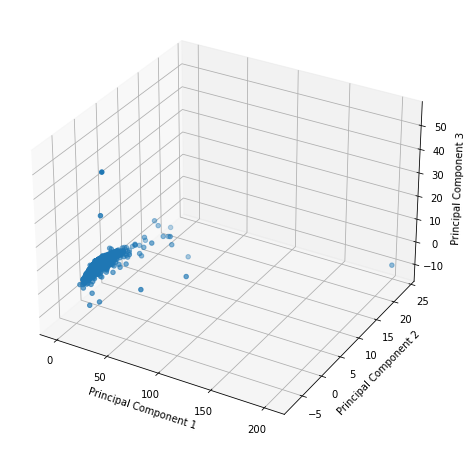

In [44]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

X_build_pca = pca.transform(X_build)
ax.scatter(X_build_pca[:,0], X_build_pca[:,1], X_build_pca[:,2], marker='o')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

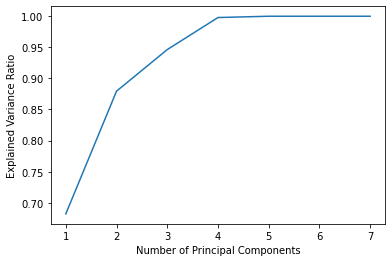

In [48]:
%matplotlib inline
plt.plot(range(1,8), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

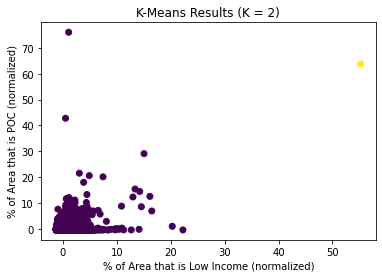

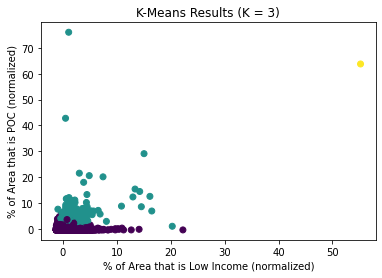

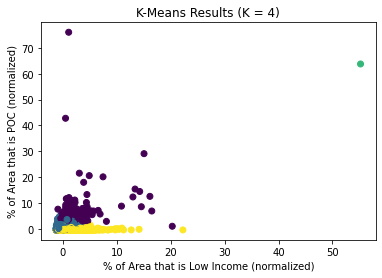

In [49]:
%matplotlib inline
for K in range(2,5):
    kmeans = KMeans(n_clusters=K).fit(X_build)
    plt.scatter(X_build[:,0], X_build[:,6], c=kmeans.labels_, cmap='viridis')
    #0= Land 
    #6= # of residential units
    plt.xlabel('% of Area that is Low Income (normalized)')
    plt.ylabel('% of Area that is POC (normalized)')
    plt.title('K-Means Results (K = ' + str(K) + ')')
    plt.show()

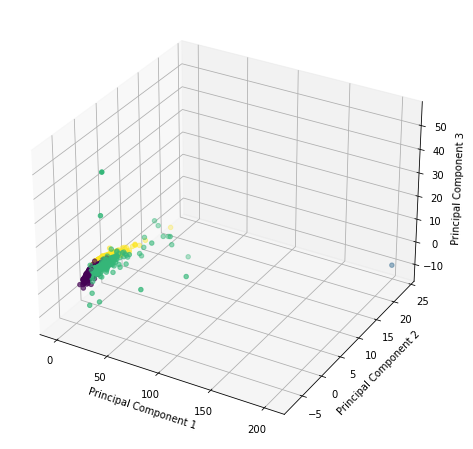

In [51]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

K = 4
model = KMeans(n_clusters=K)
GMM = model.fit(X_build)
preds = GMM.predict(X_build)

X_build_pca = pca.transform(X_build)
ax.scatter(X_build_pca[:,0], X_build_pca[:,1], X_build_pca[:,2], c=preds, cmap='viridis', marker='o')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

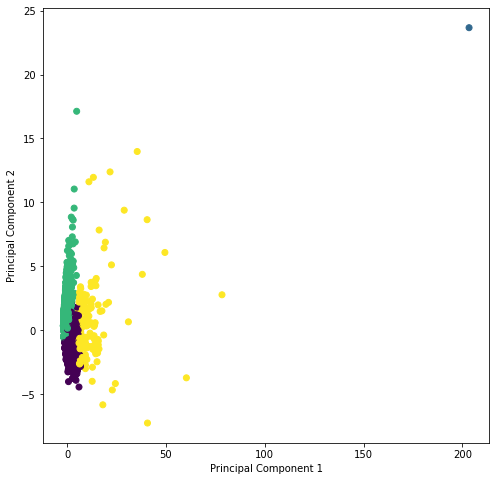

In [52]:
%matplotlib inline
fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(projection='3d')

K = 4
model = KMeans(n_clusters=K)
GMM = model.fit(X_build)
preds = GMM.predict(X_build)

X_build_pca = pca.transform(X_build)
plt.scatter(X_build_pca[:,0], X_build_pca[:,1], c=preds, cmap='viridis', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#ax.set_zlabel('Principal Component 3')
plt.show()

In [53]:
df_building['Cluster']=model.labels_

In [61]:
df_building

,address,year built,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res,Severity,Index_Sum,Cluster
0,"1 Abbotsford St, 02121",1900.0,3577.0,5528.0,3109.0,3109.0,2.0,1.0,2.0,5.000000,10,2
1,"1 Acorn St, 02108",1829.0,822.0,2939.0,2300.0,2300.0,4.0,1.0,2.0,8.000000,40,0
2,"1 Adams St, 02129",1857.0,1056.0,4093.0,3843.0,3843.0,4.0,1.0,1.0,5.000000,5,0
3,"1 Akron Pl, 02119",1890.0,1654.0,1911.0,1200.0,1200.0,2.0,1.0,1.0,5.000000,5,2
4,"1 Aldie St, 02134",1890.0,4014.0,4060.0,2623.0,2623.0,2.5,1.0,2.0,5.000000,35,2
...,...,...,...,...,...,...,...,...,...,...,...,...
25554,"992 Washington St, 02124",1935.0,4500.0,2225.0,1350.0,1350.0,2.0,1.0,1.0,4.000000,4,2
25556,"995 Centre St, 02130",1984.0,13357.0,4596.0,3042.0,3042.0,1.0,1.0,1.0,5.000000,5,2
25557,"996 South St, 02131",1907.0,5068.0,4894.0,3116.0,3116.0,2.5,1.0,2.0,4.666667,14,2
25558,"998 Tremont St, 02120",1910.0,1875.0,6705.0,5364.0,5364.0,4.0,1.0,4.0,5.769231,75,0


In [62]:
df_building.Cluster.value_counts()

2    13569
0    10833
3      205
1        1
Name: Cluster, dtype: int64

In [54]:
df_building.groupby('Cluster')['Severity'].mean()

Cluster
0    5.538486
1    9.000000
2    5.702842
3    5.547769
Name: Severity, dtype: float64

In [55]:
df_building.corr()['Severity']

year built     0.018328
land_sf        0.001462
gross_area    -0.015744
living_area   -0.012078
sqft          -0.012125
num_floors    -0.045816
num_bldgs           NaN
units_res     -0.019192
Severity       1.000000
Index_Sum      0.004332
Cluster        0.043516
Name: Severity, dtype: float64

In [57]:
df_building_clusters=df_building.groupby('Cluster').mean()

In [58]:
df_building_clusters

,year built,land_sf,gross_area,living_area,sqft,num_floors,num_bldgs,units_res,Severity,Index_Sum
Cluster,,,,,,,,,,
0,1904.980522,3030.307025,5060.250992,3567.180652,3567.593003,3.050678,1.0,3.090557,5.538486,34.460999
1,1964.000000,174782.000000,445701.000000,398510.000000,398510.000000,29.000000,1.0,273.000000,9.000000,54.000000
2,1919.260299,5162.202938,3505.615668,2091.035252,2091.380930,1.911127,1.0,1.458472,5.702842,18.672931
3,1932.331707,11364.204878,26085.180488,21995.541463,21995.541463,4.146341,1.0,29.356098,5.547769,74.078049
